In [1]:
# Bayesian views on splines

In [3]:
library(greta)
library(gamair)
options(repr.plot.width=6, repr.plot.height=4)


Attaching package: ‘greta’

The following objects are masked from ‘package:stats’:

    binomial, cov2cor, poisson

The following objects are masked from ‘package:base’:

    %*%, apply, backsolve, beta, chol2inv, colMeans, colSums, diag,
    eigen, forwardsolve, gamma, identity, rowMeans, rowSums, sweep,
    tapply



In [4]:
data(engine)

In [5]:
tf.X <- function(x, xj)
{
    tf <- function(x, xj, k) 
    {
        dj <- xj * 0
        dj[j] <- 1
        approx(xj, dj, x)$y
    }
    nk <- length(xj)
    n <- length(x)
    X <- matrix(0, n, nk)
    for (j in seq(nk)) X[,j] <- tf(x, xj, j)
    X
}

In [6]:
size <- engine$size
wear <- engine$wear

In [7]:
sj <- seq(min(size), max(size), length=6)
X <- tf.X(size, sj)
b <- lm(wear ~ X - 1)

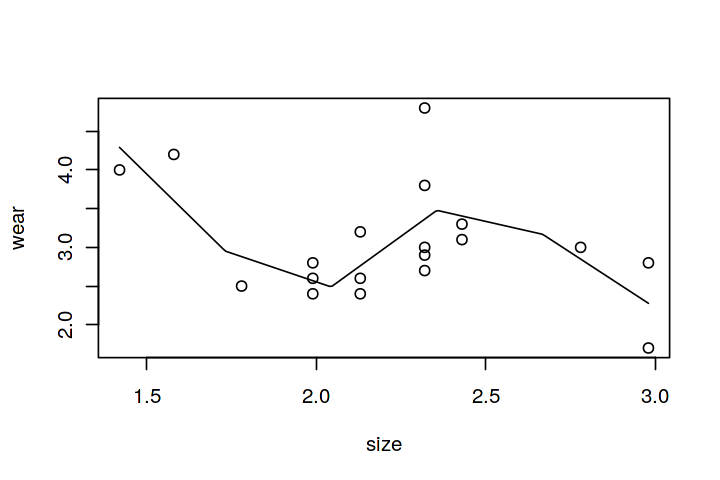

In [8]:
s <- seq(min(size), max(size), length=200)
Xp <- tf.X(s, sj)
plot(size, wear)
lines(s, Xp %*% coef(b))

In [9]:
dim(X)

[1] 19  6

In [10]:
beta <- greta::normal(0, 10, dim=6)
sd <- greta::uniform(0, 5)
wear <- as_data(wear)
distribution(wear) <- normal(X %*% beta, sd)

In [11]:
m <- model(beta, sd)

In [12]:
samples <- greta::mcmc(m)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


In [13]:
posterior <- as.matrix(samples)[,-7]

In [14]:
head(posterior)

"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]"
4.517612,2.881832,2.364411,3.203775,3.163769,2.459847
4.331204,3.212430,2.542377,3.603342,3.784778,2.446863
4.244045,3.686177,2.488215,2.919395,2.977465,2.332237
3.540788,2.981134,2.520702,3.528396,3.315178,2.288719
3.540788,2.981134,2.520702,3.528396,3.315178,2.288719
4.082349,3.089462,2.462251,3.153855,4.041568,2.223558


In [15]:
posterior_quants <- apply(as.matrix(samples), 2, quantile, c(.025, .5, .975))
posterior_quants

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]",sd
2.5%,3.043877,1.610424,1.707397,2.830512,1.203690,1.355258,0.4512446
50%,4.289589,2.928509,2.500852,3.477834,3.187695,2.272511,0.6499198
97.5%,5.550838,4.291151,3.271681,4.110511,5.089451,3.225072,1.0268240


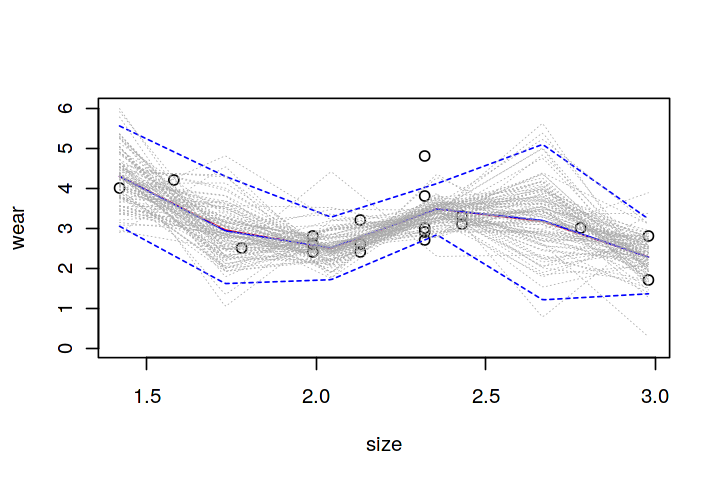

In [22]:
plot(size, wear, ylim=c(0, 6))
lines(s, Xp %*% coef(b), col="red")
lines(s, Xp %*% posterior_quants[1,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[3,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[2,1:6], col="blue", lty=1)
for (i in sample(nrow(posterior), 100)) {
    lines(s, Xp %*% posterior[i,], col="darkgrey", lty=3, lwd=.5)
}

In [17]:
sample(100, 10)

[1] 34 28 30 65 77 33 48 73 42 80